<a href="https://colab.research.google.com/github/ThatManRong/RL_Thesis/blob/Single-Asset/HeapMap_Jan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generate Sample Paths

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [2]:
def SimPaths(S0, kappa, theta, sigma, T, Ndt, Nsims):
    
    # time grid
    t = np.linspace(0, T, Ndt+1)
    dt = t[1]-t[0]
    sqrt_dt = np.sqrt(dt)

    # effective vol for large time steps
    #   sigma_eff = sigma *sqrt( (1-exp(-2*kappa*dt)) / (2*kappa) )
    #             ~ sigma *sqrt(  ( 1 - (1-2*kappa*dt + ..) ) /(2 *kappa) )
    #             ~ sigma *sqrt(  dt )
    sigma_eff = sigma * np.sqrt( (1-np.exp(-2*kappa*dt)) / (2*kappa))

    # store the sample paths
    X = np.zeros((Nsims, Ndt+1))
    Y = np.zeros((Nsims, Ndt+1))
    Z = np.zeros((Nsims, Ndt+1))

    X[:,0] = S0[0]
    Y[:,0] = S0[1]
    Z[:,0] = S0[2]


    for i in range(Ndt):

#         # Euler discretization of the SDE
#         #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
#         dW_x = sqrt_dt * np.random.randn(Nsims)
#         X[:,i+1] = X[:,i]  + kappa[0] * (theta[0] - X[:,i]) * dt + sigma[0] * dW_x

#         # Euler discretization of the SDE
#         #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
#         dW_y = sqrt_dt * np.random.randn(Nsims)
#         Y[:,i+1] = Y[:,i] + kappa[1] * (theta[1] - Y[:,i]) * dt + sigma[1] * dW_y

        # Exact solution to the SDE
        #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
        N_x =  np.random.randn(Nsims)
        X[:,i+1] = theta[0] + (X[:,i]-theta[0])*np.exp(-kappa[0]*dt) + sigma_eff[0] * N_x
        
        # Euler discretization of the SDE
        #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
        N_y = np.random.randn(Nsims)
        Y[:,i+1] = theta[1] + (Y[:,i]-theta[1])*np.exp(-kappa[1]*dt) + sigma_eff[1] * N_y

        # update Z according to no-arbitrage
        Z[:,i+1] = 1.0/(X[:,i+1]*Y[:,i+1])
        
    return t, X, Y, Z

In [156]:
# model paramteres on hourly time scales
kappa = np.array([2, 2])
theta = np.array([1, 1.1])
sigma = np.array([1, 1])*1e-2

# initial values of the FX rates
X0 = 1.000
Y0 = 1.1 #1.0995
Z0 = 1.0/(X0*Y0)

T = 1 # in minutes
Ndt = 100 # in miliseconds

Nsims = 30000 # number of sims

t, X, Y, Z = SimPaths([X0, Y0, Z0], kappa, theta, sigma, T, Ndt, Nsims)

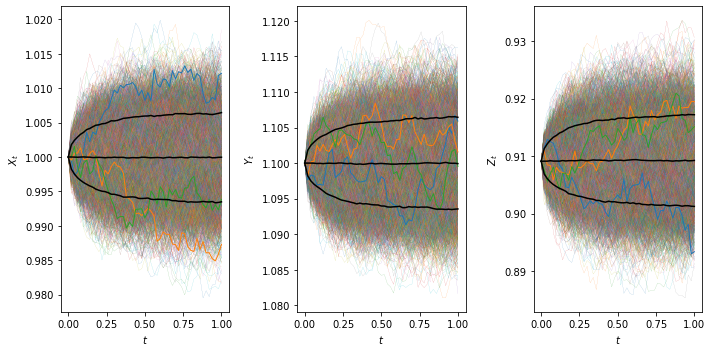

In [4]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(t, X.T, linewidth=0.1)
plt.plot(t, X[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(X,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$X_t$')

plt.subplot(1,3,2)
plt.plot(t, Y.T, linewidth=0.1)
plt.plot(t, Y[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Y,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Y_t$')

plt.subplot(1,3,3)
plt.plot(t, Z.T, linewidth=0.1)
plt.plot(t, Z[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Z,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Z_t$')

fig.tight_layout()

plt.show()

In [72]:
import pandas as pd
data = {'Time': t, 
        'X': X[0],
        'Y' : Y[0],
        'Z': Z[0]}
  
# Convert the dictionary into DataFrame 
data = pd.DataFrame(data) 
print(data)

       Time         X         Y         Z
0     0.000  1.000000  1.100000  0.909091
1     0.001  1.000557  1.100645  0.908052
2     0.002  1.000855  1.100646  0.907781
3     0.003  1.000746  1.100762  0.907784
4     0.004  1.000621  1.100431  0.908171
...     ...       ...       ...       ...
996   0.996  0.996335  1.101316  0.911345
997   0.997  0.996455  1.101343  0.911213
998   0.998  0.996378  1.101027  0.911545
999   0.999  0.996214  1.100999  0.911718
1000  1.000  0.996156  1.100666  0.912047

[1001 rows x 4 columns]


In [6]:
# train_test_split = 0.5
# train = data[:int(train_test_split*len(data))]
# test = data[int(train_test_split*len(data)):]

#State: 
>$S_t=(X_t, P_t) $

where X is inventory and P is price

#Action: 
>$a_t = \{Buy, Sell, Hold\} $

#State Evolution
>$X_{t+1}= X_t + a_t $

>$P_{t+1}= f(P_t) + \epsilon $

In [106]:
class Environment2:
    
    def __init__(self, data, history_t = 10):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0

        # act = 0: sell, 
        #1: stay, 
        #2: buy
        if (self.t + 1 ==len(self.data)-1):
          act == 0
        max_holding = 8
        if act == 2:
            if len(self.positions)>=max_holding:
              reward = -1
            else:
              self.positions.append(self.data.iloc[self.t, :]['X'])
        elif act == 0: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['X'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        if len(self.positions)>=max_holding:
          reward = -1
        # set next time
        self.t += 1
        #print(self.t)
        # if self.t == 49 and self.positions != [] and act != 2:
        #   reward = -1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['X'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['X'] - 1.0000)
        if (self.t==len(self.data)-1):
            self.done=True
            #self.positions = []
            #act = 2   #Force selling at end of period

        # if self.done and self.positions != []:
        #   reward = -1
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        #actual_action = act
        return [self.position_value] + self.history, reward, self.done, self.positions # obs, reward, done

In [94]:
class Environment1:
    
    def __init__(self, data, history_t=20):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0

        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if len(self.positions)>=20:
              reward = -1
            else:
              self.positions.append(self.data.iloc[self.t, :]['X'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['X'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        if len(self.positions)>=10:
          reward = -1
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['X'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['X'] - 1.0000)
        if (self.t==len(self.data)-1):
            self.done=True
            #self.positions = []
            #act = 2   #Force selling at end of period


        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        actual_action = act
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [107]:
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)

In [108]:
hidden_size=20
input_size=11
output_size=3
USE_CUDA = False
LR = 0.001

In [109]:
Q = Q_Network(input_size, hidden_size, output_size)

In [110]:
Q_ast = copy.deepcopy(Q)


In [111]:
if USE_CUDA:
    Q = Q.cuda()
    print("using Cuda")
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

In [112]:
#epoch_num = 20
memory_size = 4000
batch_size = 200
gamma = 0.99

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.01
start_reduce_epsilon = 200
train_freq = 10
update_q_freq = 20
gamma = 0.99
show_log_freq = 20


In [15]:
# epoch_data = {'Time': t, 
#         'X': X[1]}
# epoch_data = pd.DataFrame(epoch_data) 
# env = Environment2(epoch_data)
# step_max = len(env.data)-1

In [113]:
master_reward = []
#start = time.time()
for epoch in range(len(X[:int(Nsims/2)])):
    epoch_data = {'Time': t, 
        'X': X[epoch]}
    print("Percentage done: ", epoch/int(Nsims/2))
    epoch_data = pd.DataFrame(epoch_data) 
    env = Environment2(epoch_data)
    step_max = len(env.data)-1
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0
    iterations = []
    log_rewards = []
    log_losses = []
    iteration = 1
    trading_history = []
    while not done and step < step_max:
        if done:
          trading_history = []  #For pair trading, make sure the stock
        # select action
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:  #Epsilon greedy Exploration
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()
        if step == step_max - 1:
           pact = 2
        # act
        obs, reward, done, inventory = env.step(pact)
        #print("Step max is: ", step_max, "Inventory is: ", inventory)
        # if done is True:
        #     print("action is: ", actual_action, "  Reward is: ", reward, "  Done? ", done)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        #memory.append((pobs, actual_action, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        master_reward.append(total_rewards)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            
            iterations.append(iteration)
            iteration += 1
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_rewards.append(log_reward)
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_losses.append(log_loss)
            #elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss])))
            #start = time.time()
            
#return Q, total_losses, total_rewards

Percentage done:  0.0
Percentage done:  0.0003333333333333333
Percentage done:  0.0006666666666666666
Percentage done:  0.001
Percentage done:  0.0013333333333333333
Percentage done:  0.0016666666666666668
Percentage done:  0.002
Percentage done:  0.0023333333333333335
Percentage done:  0.0026666666666666666
Percentage done:  0.003
Percentage done:  0.0033333333333333335
Percentage done:  0.0036666666666666666
Percentage done:  0.004
Percentage done:  0.004333333333333333
Percentage done:  0.004666666666666667
Percentage done:  0.005
Percentage done:  0.005333333333333333
Percentage done:  0.005666666666666667
Percentage done:  0.006
Percentage done:  0.006333333333333333
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	0.0
20	1.0	0	0.0	

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Streaming output truncated to the last 5000 lines.
1980	0.00999999999999912	193934	18141.3	5581705.88949413
1980	0.00999999999999912	193935	18141.35	5581706.505846916
1980	0.00999999999999912	193936	18141.4	5581707.122199702
1980	0.00999999999999912	193937	18141.45	5581707.738552488
1980	0.00999999999999912	193938	18141.5	5581708.354905275
1980	0.00999999999999912	193939	18141.55	5581708.971258061
1980	0.00999999999999912	193940	18141.6	5581709.587610846
1980	0.00999999999999912	193941	18141.65	5581710.426492618
1980	0.00999999999999912	193942	18141.7	5581711.2653743895
1980	0.00999999999999912	193943	18141.75	5581712.104256161
1980	0.00999999999999912	193944	18141.8	5581712.943137932
1980	0.00999999999999912	193945	18141.85	5581713.782019703
1980	0.00999999999999912	193946	18141.9	5581714.620901475
1980	0.00999999999999912	193947	18141.95	5581715.459783246
1980	0.00999999999999912	193948	18142.0	5581716.298665017
1980	0.00999999999999912	193949	18142.05	5581717.137546788
1980	0.009999

KeyboardInterrupt: ignored

In [ ]:
print(len(total_rewards[:-600]))

In [ ]:
t_in_ms = [i for i in range(100)]
fig = plt.figure(figsize=(30,5))
plt.subplot(1,5,1)
plt.plot(t_in_ms, total_rewards[600:700], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,2)
plt.plot(t_in_ms, total_rewards[9600:9700], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,3)
plt.plot(t_in_ms, total_rewards[19200:19300], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
# plt.subplot(1,5,4)
# plt.plot(t_in_ms, total_rewards[30000:30100], linewidth=1)
# plt.xlabel('$t$')
# plt.ylabel('$Rewards$')
# plt.subplot(1,5,5)
# plt.plot(t_in_ms, total_rewards[40000:40100], linewidth=1)
# plt.xlabel('$t$')
# plt.ylabel('$Rewards$')

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(iterations, log_rewards, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Rewards')
plt.subplot(1,2,2)
plt.plot(iterations, log_losses, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Losses')

In [ ]:
print(len(log_rewards))
incremental_reward = []
for i in range(len(log_rewards)):
  if i>=1:
    incremental_reward.append((log_rewards[i]-log_rewards[i-1])/memory_size)


In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(iterations[:-1], incremental_reward, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('incremental_reward')

In [114]:
test_data = {'Time': t, 
        'X': X[1000]}
test_data = pd.DataFrame(test_data) 
test_env = Environment2(test_data)

In [115]:
#test_env = Environment1(X[100])
pobs = test_env.reset()
test_acts = []
test_rewards = []
inventory = []
for _ in range(len(test_env.data)-1):
    
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    
    #print(pact.numpy())        
    obs, reward, done, epoch_inventory = test_env.step(pact.numpy())
    inventory.append(len(epoch_inventory))
    test_acts.append(pact.numpy())
    test_rewards.append(reward)

    pobs = obs
        
test_profits = test_env.profits

In [47]:
print(len(inventory))

50


In [116]:
buy_point = []
buy_time = []
sell_point = []
sell_time = []
for i in range(len(test_acts)):
  if test_acts[i] == 2:
    buy_point.append(X[1000][i])
    buy_time.append(i/len(test_acts))
  if test_acts[i] == 0:
    sell_point.append(X[1000][i])
    sell_time.append(i/len(test_acts))

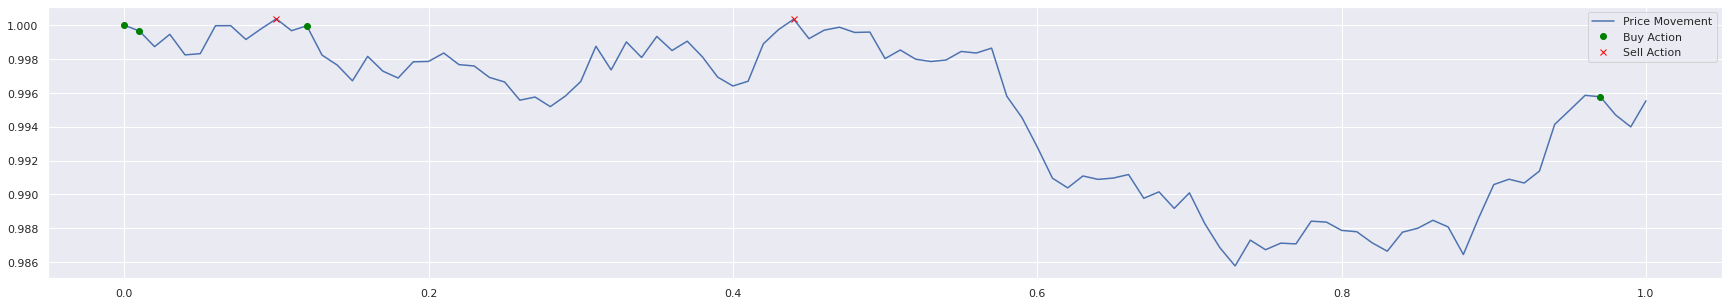

In [117]:
fig = plt.figure(figsize=(30,5))
plt.plot(t,X[1000])
plt.plot(buy_time, buy_point, 'o', color='green')
plt.plot(sell_time, sell_point, 'x', color='red');
plt.legend(["Price Movement","Buy Action","Sell Action"])
#print(mark)
plt.show()

In [ ]:
t_in_ms = [i for i in range(len(test_rewards))]
plt.plot(t_in_ms, test_rewards, linewidth=1)

In [119]:
print(test_profits)

0.0014766291209185045


In [157]:
#Try all sample path
samplepath_number = []
test_profits = []
actions = []
all_inventory = []
for i in range(0,len(X)):
  epoch_action = []
  inventory = []
  test_data = {'Time': t, 
        'X': X[i]}
  # Convert the dictionary into DataFrame 
  test_data = pd.DataFrame(test_data) 
  test_env = Environment2(test_data)
  pobs = test_env.reset()
  test_acts = []
  test_rewards = []
  print("Percentage done: ", i*100/len(X))
  for i in range(len(test_env.data)-1):
      #inventory.append(0)
      pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
      pact = np.argmax(pact.data)
      test_acts.append(pact.item())
      #print(pact.numpy())        
      # if pact.numpy() == 1:
      #   if i > 0:
      #     inventory[i] = inventory[i-1]+1

      obs, reward, done, epoch_inventory = test_env.step(pact.numpy())
      inventory.append(len(epoch_inventory))
      epoch_action.append(pact.numpy())
      test_rewards.append(reward)

      pobs = obs
  epoch_action[99] = 0
  actions.append(epoch_action)
  all_inventory.append(inventory)        
  test_profits.append(test_env.profits)
  samplepath_number.append(i+1)




Streaming output truncated to the last 5000 lines.
Percentage done:  83.33333333333333
Percentage done:  83.33666666666667
Percentage done:  83.34
Percentage done:  83.34333333333333
Percentage done:  83.34666666666666
Percentage done:  83.35
Percentage done:  83.35333333333334
Percentage done:  83.35666666666667
Percentage done:  83.36
Percentage done:  83.36333333333333
Percentage done:  83.36666666666666
Percentage done:  83.37
Percentage done:  83.37333333333333
Percentage done:  83.37666666666667
Percentage done:  83.38
Percentage done:  83.38333333333334
Percentage done:  83.38666666666667
Percentage done:  83.39
Percentage done:  83.39333333333333
Percentage done:  83.39666666666666
Percentage done:  83.4
Percentage done:  83.40333333333334
Percentage done:  83.40666666666667
Percentage done:  83.41
Percentage done:  83.41333333333333
Percentage done:  83.41666666666667
Percentage done:  83.42
Percentage done:  83.42333333333333
Percentage done:  83.42666666666666
Percentage don

In [162]:
print(all_inventory[100])
print(actions[100])

[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[array(2), array(0), array(2), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(2), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(2), array(1), array(1), array(1), array(1), array(0), array(2), array(0), array(2), array(1), array(1), array(0), array(1), array(1), array(1), array(1), array(2), array(2), array(2), array(2), array(1), array(0), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(2), array(1), array(0), array(1)

In [161]:
#Offset the inventory
updated_all_inventory = all_inventory
for i in range(len(all_inventory)):
  updated_all_inventory[i].insert(0,0)
  #del updated_all_inventory[i][0]
  del updated_all_inventory[i][len(all_inventory[0])-1]
  #updated_all_inventory[i][len(all_inventory[0])-1] = 0
print(updated_all_inventory[2])
print(len(updated_all_inventory[2]))

[0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
100


In [124]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

In [ ]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)

In [ ]:
print(flights)

In [163]:
#Begin of the day: t = 0
time_spot = 0
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  price_spot.append(X[i][time_spot])
  inventory_spot.append(updated_all_inventory[i][time_spot])
  action_spot.append(actions[i][time_spot])
price_quartile = []
for i in range(len(price_spot)):
  if price_spot[i] <= np.quantile(price_spot,0.25):
    price_quartile.append(1)
  elif np.quantile(price_spot,0.25) < price_spot[i] <= np.quantile(price_spot,0.5):
    price_quartile.append(2)
  elif np.quantile(price_spot,0.5) < price_spot[i] <= np.quantile(price_spot,0.75):
    price_quartile.append(3)
  elif np.quantile(price_spot,0.75) < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

In [137]:
print(df)
print(len(action_spot))

      price  inventory  action
0         1          0       2
1         1          0       2
2         1          0       2
3         1          0       2
4         1          0       2
...     ...        ...     ...
5995      1          0       2
5996      1          0       2
5997      1          0       2
5998      1          0       2
5999      1          0       2

[6000 rows x 3 columns]
6000


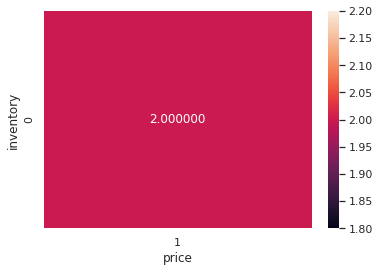

In [164]:
#df = sns.load_dataset("flights")
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#print(table)
ax = sns.heatmap(table, annot=True, fmt="f")


In [165]:
#End of the day: t = 99
time_spot = 99
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  price_spot.append(X[i][time_spot])
  inventory_spot.append(updated_all_inventory[i][time_spot])
  action_spot.append(actions[i][time_spot])
price_quartile = []
for i in range(len(price_spot)):
  if price_spot[i] <= np.quantile(price_spot,0.25):
    price_quartile.append(1)
  elif np.quantile(price_spot,0.25) < price_spot[i] <= np.quantile(price_spot,0.5):
    price_quartile.append(2)
  elif np.quantile(price_spot,0.5) < price_spot[i] <= np.quantile(price_spot,0.75):
    price_quartile.append(3)
  elif np.quantile(price_spot,0.75) < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

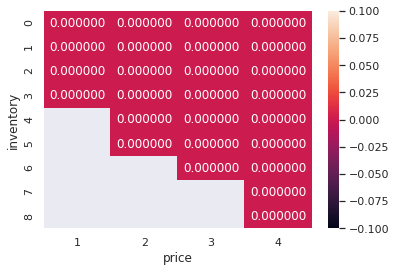

In [166]:
#df = sns.load_dataset("flights")
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#print(table)
ax = sns.heatmap(table, annot=True, fmt="f")


In [249]:
#Middle of the day: t = 25 to t = 75
time_spot = 25
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  for j in range(5,95):
    price_spot.append(X[i][j])
    inventory_spot.append(all_inventory[i][j])
    action_spot.append(actions[i][j])
price_quartile = []
print("Loaded")
first_quantile = np.quantile(price_spot,0.1)
second_quantile = np.quantile(price_spot,0.5)
third_quantile = np.quantile(price_spot,0.9)
print("Done")
for i in range(len(price_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot[i] <= first_quantile:
    price_quartile.append(1)
  elif first_quantile < price_spot[i] <= second_quantile:
    price_quartile.append(2)
  elif second_quantile < price_spot[i] <= third_quantile:
    price_quartile.append(3)
  elif third_quantile < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

Loaded
Done


In [238]:
def remove_outlier(df):
  for i in range(len(df)):
    for j in range(1,5):
      if df.xs(i)[j] == 1.00000 or df.xs(i)[j] == 0.00000 or df.xs(i)[j] == 2.00000:
        df.xs(i)[j] = float("NaN")
  return df
      

In [193]:
print(table.xs(1)[2])
#df.xs('C')['x'] = 10

1.0005419962399011


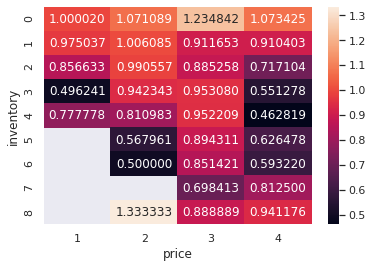

In [250]:
#df = sns.load_dataset("flights")
#from scipy import stats
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
table = remove_outlier(table)
#print(table)
ax = sns.heatmap(table, annot=True, fmt="f")


In [247]:
#Near end of the day: t = 95 to t = 100
#time_spot = 25
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  for j in range(95,100):
    price_spot.append(X[i][j])
    inventory_spot.append(all_inventory[i][j])
    action_spot.append(actions[i][j])
price_quartile = []
print("Loaded")
first_quantile = np.quantile(price_spot,0.1)
second_quantile = np.quantile(price_spot,0.5)
third_quantile = np.quantile(price_spot,0.9)
print("Done")
for i in range(len(price_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot[i] <= first_quantile:
    price_quartile.append(1)
  elif first_quantile < price_spot[i] <= second_quantile:
    price_quartile.append(2)
  elif second_quantile < price_spot[i] <= third_quantile:
    price_quartile.append(3)
  elif third_quantile < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

Loaded
Done


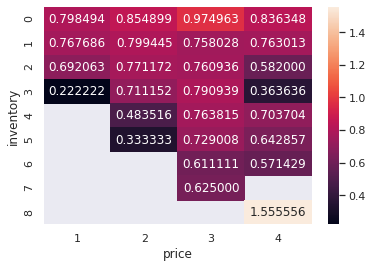

In [248]:
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
table = remove_outlier(table)

#print(table)
ax = sns.heatmap(table[:], annot=True, fmt="f")

In [244]:
#Beginning of the day: t = 0 to t = 5
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  for j in range(0,5):
    price_spot.append(X[i][j])
    inventory_spot.append(all_inventory[i][j])
    action_spot.append(actions[i][j])
price_quartile = []
print("Loaded")
first_quantile = np.quantile(price_spot,0.1)
second_quantile = np.quantile(price_spot,0.5)
third_quantile = np.quantile(price_spot,0.9)
print("Done")
for i in range(len(price_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot[i] <= first_quantile:
    price_quartile.append(1)
  elif first_quantile < price_spot[i] <= second_quantile:
    price_quartile.append(2)
  elif second_quantile < price_spot[i] <= third_quantile:
    price_quartile.append(3)
  elif third_quantile < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

Loaded
Done


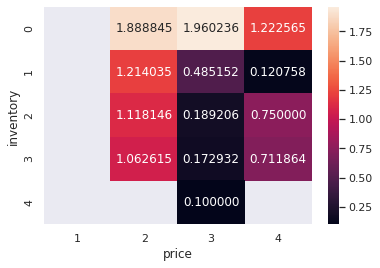

In [245]:
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
table = remove_outlier(table)

#print(table)
ax = sns.heatmap(table[:], annot=True, fmt="f")

In [240]:
#Beginning of the day: t = 0 
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  for j in range(0,1):
    price_spot.append(X[i][j])
    inventory_spot.append(all_inventory[i][j])
    action_spot.append(actions[i][j])
price_quartile = []
print("Loaded")
first_quantile = np.quantile(price_spot,0.1)
second_quantile = np.quantile(price_spot,0.5)
third_quantile = np.quantile(price_spot,0.9)
print("Done")
for i in range(len(price_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot[i] <= first_quantile:
    price_quartile.append(1)
  elif first_quantile < price_spot[i] <= second_quantile:
    price_quartile.append(2)
  elif second_quantile < price_spot[i] <= third_quantile:
    price_quartile.append(3)
  elif third_quantile < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

Loaded
Done


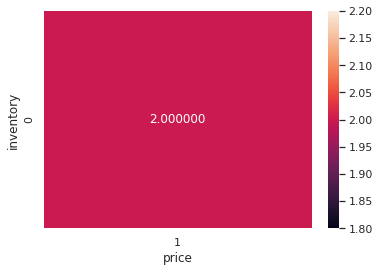

In [241]:
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#table = remove_outlier(table)

#print(table)
ax = sns.heatmap(table[:], annot=True, fmt="f")

In [242]:
#End of the day: t = 99 
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  for j in range(99,100):
    price_spot.append(X[i][j])
    inventory_spot.append(all_inventory[i][j])
    action_spot.append(actions[i][j])
price_quartile = []
print("Loaded")
first_quantile = np.quantile(price_spot,0.1)
second_quantile = np.quantile(price_spot,0.5)
third_quantile = np.quantile(price_spot,0.9)
print("Done")
for i in range(len(price_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot[i] <= first_quantile:
    price_quartile.append(1)
  elif first_quantile < price_spot[i] <= second_quantile:
    price_quartile.append(2)
  elif second_quantile < price_spot[i] <= third_quantile:
    price_quartile.append(3)
  elif third_quantile < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

Loaded
Done


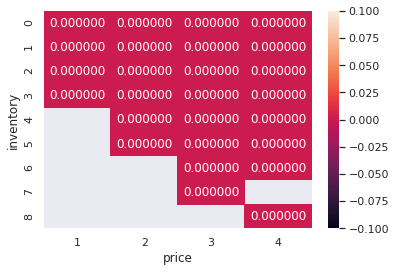

In [243]:
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#table = remove_outlier(table)

#print(table)
ax = sns.heatmap(table[:], annot=True, fmt="f")

(array([7.000e+00, 2.800e+01, 6.400e+01, 8.400e+01, 1.210e+02, 6.890e+02,
        1.855e+03, 2.887e+03, 2.168e+03, 9.220e+02, 5.042e+03, 7.573e+03,
        5.131e+03, 2.333e+03, 7.870e+02, 2.370e+02, 5.000e+01, 1.400e+01,
        4.000e+00, 4.000e+00]),
 array([-0.03909559, -0.03516176, -0.03122792, -0.02729408, -0.02336025,
        -0.01942641, -0.01549257, -0.01155874, -0.0076249 , -0.00369106,
         0.00024278,  0.00417661,  0.00811045,  0.01204429,  0.01597812,
         0.01991196,  0.0238458 ,  0.02777963,  0.03171347,  0.03564731,
         0.03958114]),
 <a list of 20 Patch objects>)

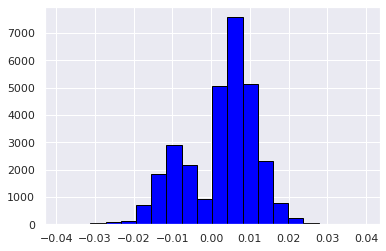

In [158]:
plt.hist(test_profits, color = 'blue', edgecolor = 'black',
         bins = 20)

In [159]:
YEAH = 0
NOOOO = 0
for elem in test_profits:
  if elem >= 0.0:
    YEAH += 1
  else:
    NOOOO -= 1

print("Percentage of Profitting: ", YEAH*100/(len(test_profits)),"%")

Percentage of Profitting:  71.07333333333334 %
